# Setup

Dependencies:
- System: python3
- Python: jupyter, numpy, matplotlib, jax

In [9]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt; plt.rcParams.update({'font.size': 20})
from ipywidgets import interact

# `NamedTuple`s are used (more accurately, abused) in this notebook to minimize dependencies;
# much better JAX-compatible choices to fit the archetype of "parameterized function" would be
# `flax.struct.dataclass` or `equinox.Module`.
from typing import Callable, NamedTuple

In [10]:
# Notation from https://github.com/StanfordASL/AA203-Notes/blob/master/notes.pdf;
# notation from https://asl.stanford.edu/aa203/pdfs/lecture/lectures_9_and_10.pdf in comments.


class LinearDynamics(NamedTuple):
    f_x: jnp.array  # A
    f_u: jnp.array  # B

    def __call__(self, x, u, k=None):
        f_x, f_u = self
        return f_x @ x + f_u @ u if k is None else self[k](x, u)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)


class AffinePolicy(NamedTuple):
    l: jnp.array  # l
    l_x: jnp.array  # L

    def __call__(self, x, k=None):
        l, l_x = self
        return l + l_x @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)


class QuadraticCost(NamedTuple):
    c: jnp.array  # c
    c_x: jnp.array  # q
    c_u: jnp.array  # r
    c_xx: jnp.array  # Q
    c_uu: jnp.array  # R
    c_ux: jnp.array  # H.T

    @classmethod
    def from_pure_quadratic(cls, c_xx, c_uu, c_ux):
        return cls(
            jnp.zeros((c_xx.shape[:-2])),
            jnp.zeros(c_xx.shape[:-1]),
            jnp.zeros(c_uu.shape[:-1]),
            c_xx,
            c_uu,
            c_ux,
        )

    def __call__(self, x, u, k=None):
        c, c_x, c_u, c_xx, c_uu, c_ux = self
        return c + c_x @ x + c_u @ u + x @ c_xx @ x / 2 + u @ c_uu @ u / 2 + u @ c_ux @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)


class QuadraticStateCost(NamedTuple):
    v: jnp.array  # p (scalar)
    v_x: jnp.array  # p (vector)
    v_xx: jnp.array  # P

    @classmethod
    def from_pure_quadratic(cls, v_xx):
        return cls(
            jnp.zeros(v_xx.shape[:-2]),
            jnp.zeros(v_xx.shape[:-1]),
            v_xx,
        )

    def __call__(self, x, k=None):
        v, v_x, v_xx = self
        return v + v_x @ x + x @ v_xx @ x / 2 if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree.map(lambda x: x[key], self)


def rollout_state_feedback_policy(dynamics, policy, x0, step_range, x_nom=None, u_nom=None):

    def scan_fn(x, k):
        u = policy(x, k) if x_nom is None else u_nom[k] + policy(x - x_nom[k], k)
        x1 = dynamics(x, u, k)
        return (x1, (x1, u))

    xs, us = jax.lax.scan(scan_fn, x0, step_range)[1]
    return jnp.concatenate([x0[None], xs]), us

## [Discrete-time, finite-horizon] Linear Quadratic Regulator (LQR)
Minimizing a quadratic regulation cost:

$
J_k(\mathbf{x}_k) = \frac{1}{2}Q_N \|\mathbf{x}_N\|^2 + \frac{1}{2}\sum_{i=k}^{N-1} \left(\|\mathbf{x}_k\|^2 + \|\mathbf{u}_k\|^2\right)
$

subject to single-integrator dynamics with a time discretization of $\Delta t$:

$\begin{bmatrix}p_{k+1} \\ v_{k+1}\end{bmatrix} =
\begin{bmatrix}1 & \Delta t \\ 0 & 1\end{bmatrix} \begin{bmatrix}p_k \\ v_k\end{bmatrix} +
\begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix} \begin{bmatrix}u_k\end{bmatrix}.
$

In [11]:
def riccati_step(
    current_step_dynamics: LinearDynamics,
    current_step_cost: QuadraticCost,
    next_state_value: QuadraticStateCost,
):
    f_x, f_u = current_step_dynamics
    c, c_x, c_u, c_xx, c_uu, c_ux = current_step_cost
    v, v_x, v_xx = next_state_value

    q = c + v
    q_x = c_x + f_x.T @ v_x
    q_u = c_u + f_u.T @ v_x
    q_xx = c_xx + f_x.T @ v_xx @ f_x
    q_uu = c_uu + f_u.T @ v_xx @ f_u
    q_ux = c_ux + f_u.T @ v_xx @ f_x

    l = -jnp.linalg.solve(q_uu, q_u)
    l_x = -jnp.linalg.solve(q_uu, q_ux)

    current_state_value = QuadraticStateCost(
        q - l.T @ q_uu @ l / 2,
        q_x - l_x.T @ q_uu @ l,
        q_xx - l_x.T @ q_uu @ l_x,
    )
    current_step_optimal_policy = AffinePolicy(l, l_x)
    return current_state_value, current_step_optimal_policy


@jax.jit
def linear_quadratic_regulator(Qs, Rs, Hs, As, Bs):
    final_state_value = QuadraticStateCost.from_pure_quadratic(Qs[-1])
    dynamics = LinearDynamics(As, Bs)
    cost = QuadraticCost.from_pure_quadratic(Qs[:-1], Rs, Hs)

    def scan_fn(next_state_value, current_step_dynamics_cost):
        current_step_dynamics, current_step_cost = current_step_dynamics_cost
        current_state_value, current_step_optimal_policy = riccati_step(
            current_step_dynamics,
            current_step_cost,
            next_state_value,
        )
        return current_state_value, (current_state_value, current_step_optimal_policy)

    value_functions, optimal_policy = jax.lax.scan(scan_fn, final_state_value, (dynamics, cost), reverse=True)[1]
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), value_functions, final_state_value[None]), optimal_policy

In [12]:
N = 10
dt = 0.5
Q_N = 1  # Change to 100!

Qs = np.broadcast_to(np.eye(2), (N + 1, 2, 2)).copy()
Qs[-1] *= Q_N
Rs = np.broadcast_to(np.eye(1), (N, 1, 1))
Hs = np.broadcast_to(np.zeros((1, 2)), (N, 1, 2))
As = np.broadcast_to(np.array([[1, dt], [0, 1]]), (N, 2, 2))
Bs = np.broadcast_to(np.array([[dt**2 / 2], [dt]]), (N, 2, 1))
value_functions, optimal_policy = linear_quadratic_regulator(Qs, Rs, Hs, As, Bs)

In [13]:
X0, X1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
X = np.stack([X0, X1], -1)
all_values = jax.vmap(lambda v: jax.vmap(jax.vmap(v))(X))(value_functions)

dynamics = LinearDynamics(jnp.array(As), jnp.array(Bs))
x0s = np.random.uniform(-3, 3, (20, 2))
example_trajectories = [
    jax.vmap(lambda x0: rollout_state_feedback_policy(
        dynamics,
        optimal_policy,
        x0,
        np.arange(k, N),
    ))(x0s)[0] for k in range(N)
]


@interact(k=(0, N))
def plot(k=N):
    plt.figure(figsize=(10, 8))
    plt.contour(X0, X1, all_values[k], levels=40)
    plt.colorbar()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel("Position $p$")
    plt.ylabel("Velocity $v$")
    plt.title(f"Value Function at Step {k}")

    if k < N:
        plt.scatter(*x0s.T, color="red")
        plt.plot(*example_trajectories[k].T, color="grey", alpha=0.5)
        plt.plot(*example_trajectories[k][:, :2].T, color="red")

interactive(children=(IntSlider(value=10, description='k', max=10), Output()), _dom_classes=('widget-interact'…

## Tracking LQR for Linear Dynamics
Minimizing a quadratic tracking cost:

$
J_k(\mathbf{\delta x}_k) = \frac{1}{2}Q_N \|\mathbf{\delta x}_N\|^2 + \frac{1}{2}\sum_{i=k}^{N-1} \left(\|\mathbf{\delta x}_k\|^2 + \|\mathbf{\delta u}_k\|^2\right)
$

subject to single-integrator dynamics with a time discretization of $\Delta t$:

$\begin{bmatrix}p_{k+1} \\ v_{k+1}\end{bmatrix} =
\begin{bmatrix}1 & \Delta t \\ 0 & 1\end{bmatrix} \begin{bmatrix}p_k \\ v_k\end{bmatrix} +
\begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix} \begin{bmatrix}u_k\end{bmatrix}
$

tracking a sinusoidal nominal trajectory.

In [14]:
x_nom, u_nom = rollout_state_feedback_policy(dynamics, lambda x, k: -x[:1], np.array([0., 2.]), np.arange(N))

In [15]:
X0, X1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
X = np.stack([X0, X1], -1)
all_values = jax.vmap(lambda v, x: jax.vmap(jax.vmap(v))(X - x))(value_functions, x_nom)

dynamics = LinearDynamics(jnp.array(As), jnp.array(Bs))
x0s = np.random.uniform(-4, 4, (20, 2))
example_trajectories = [
    # Note that this is the exact same policy as above!
    jax.vmap(lambda x0: rollout_state_feedback_policy(
        dynamics,
        optimal_policy,
        x0,
        np.arange(k, N),
        x_nom,
        u_nom,
    ))(x0s)[0] for k in range(N)
]


@interact(k=(0, N))
def plot(k=N):
    plt.figure(figsize=(10, 8))
    plt.contour(X0, X1, all_values[k], levels=40)
    plt.colorbar()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel("Position $p$")
    plt.ylabel("Velocity $v$")
    plt.title(f"Value Function at Step {k}")

    if k < N:
        plt.scatter(*x0s.T, color="red")
        plt.plot(*example_trajectories[k].T, color="grey", alpha=0.5)
        plt.plot(*example_trajectories[k][:, :2].T, color="red")

    plt.plot(*x_nom.T, color="black", linewidth=4)
    plt.scatter(*x_nom[k], color="green", s=250)

interactive(children=(IntSlider(value=10, description='k', max=10), Output()), _dom_classes=('widget-interact'…

## Tracking LQR for Nonlinear Dynamics
Minimizing a quadratic tracking cost:

$
J_k(\mathbf{\delta x}_k) = \frac{1}{2}Q_N \|\mathbf{\delta x}_N\|^2 + \frac{1}{2}\sum_{i=k}^{N-1} \left(\|\mathbf{\delta x}_k\|^2 + \|\mathbf{\delta u}_k\|^2\right)
$

subject to nonlinear dynamics:

$\begin{bmatrix}p_{k+1} \\ v_{k+1}\end{bmatrix} =
\begin{bmatrix}1 & \Delta t \\ 0 & 1\end{bmatrix} \begin{bmatrix}p_k \\ v_k\end{bmatrix} +
\begin{bmatrix}\frac{1}{2}\Delta t^2 p_k \\ \Delta t\end{bmatrix} \begin{bmatrix}u_k\end{bmatrix}
$

tracking a sinusoidal nominal trajectory.

In [16]:
def simple_nonlinear_dynamics(x, u, k):
    p, v = x
    a, = u
    return jnp.array([p + v * dt + p * a * dt**2 / 2, v + a * dt])

x_nom, u_nom = rollout_state_feedback_policy(simple_nonlinear_dynamics, lambda x, k: -x[:1], np.array([0., 2.]), np.arange(N))

In [17]:
N = 10
dt = 0.5
Q_N = 1  # Change to 100!

Qs = np.broadcast_to(np.eye(2), (N + 1, 2, 2)).copy()
Qs[-1] *= Q_N
Rs = np.broadcast_to(np.eye(1), (N, 1, 1))
Hs = np.broadcast_to(np.zeros((1, 2)), (N, 1, 2))
As, Bs = jax.vmap(jax.jacobian(simple_nonlinear_dynamics, (0, 1)))(x_nom[:-1], u_nom, np.arange(10))
value_functions, optimal_policy = linear_quadratic_regulator(Qs, Rs, Hs, As, Bs)

In [18]:
X0, X1 = np.meshgrid(np.linspace(-8, 5, 100), np.linspace(-5, 5, 100))
X = np.stack([X0, X1], -1)
all_values = jax.vmap(lambda v, x: jax.vmap(jax.vmap(v))(X - x))(value_functions, x_nom)

dynamics = LinearDynamics(As, Bs)
x0s = np.random.uniform(-4, 4, (20, 2))
example_trajectories = [
    jax.vmap(lambda x0: rollout_state_feedback_policy(
        simple_nonlinear_dynamics,
        optimal_policy,
        x0,
        np.arange(k, N),
        x_nom,
        u_nom,
    ))(x0s)[0] for k in range(N)
]


@interact(k=(0, N))
def plot(k=0):
    plt.figure(figsize=(12, 8))
    plt.contour(X0, X1, all_values[k], levels=40)
    plt.colorbar()
    plt.xlim(-8, 5)
    plt.ylim(-5, 5)
    plt.xlabel("Position $p$")
    plt.ylabel("Velocity $v$")
    plt.title(f"(Locally Accurate) Value Function at Step {k}")

    if k < N:
        plt.scatter(*x0s.T, color="red")
        plt.plot(*example_trajectories[k].T, color="grey", alpha=0.5)
        plt.plot(*example_trajectories[k][:, :2].T, color="red")

    plt.plot(*x_nom.T, color="black", linewidth=4)
    plt.scatter(*x_nom[k], color="green", s=250)

interactive(children=(IntSlider(value=0, description='k', max=10), Output()), _dom_classes=('widget-interact',…

## Iterative LQR
Minimizing a nonconvex cost:

$
    J_k(\mathbf{x}_k) = 10 \|\mathbf{x}_N - [-4, 0]^T\|^2 + \sum_{i=k}^{N-1} \left(\sin^2(v_k\pi) + \|\mathbf{u}_k\|^2\right)
$

subject to nonlinear dynamics:

$\begin{bmatrix}p_{k+1} \\ v_{k+1}\end{bmatrix} =
\begin{bmatrix}1 & \Delta t \\ 0 & 1\end{bmatrix} \begin{bmatrix}p_k \\ v_k\end{bmatrix} +
\begin{bmatrix}\frac{1}{2}\Delta t^2 p_k \\ \Delta t\end{bmatrix} \begin{bmatrix}u_k\end{bmatrix}.
$

In [19]:
def ensure_positive_definite(a, eps=1e-3):
    w, v = jnp.linalg.eigh(a)
    return (v * jnp.maximum(w, eps)) @ v.T


class TotalCost(NamedTuple):
    running_cost: Callable
    terminal_cost: Callable

    def __call__(self, xs, us):
        step_range = jnp.arange(us.shape[0])
        return jnp.sum(jax.vmap(self.running_cost)(xs[:-1], us, step_range)) + self.terminal_cost(xs[-1])


@jax.jit
def iterative_linear_quadratic_regulator(dynamics, total_cost, x0, u_guess, maxiter=100, atol=1e-3):
    running_cost, terminal_cost = total_cost
    n, (N, m) = x0.shape[-1], u_guess.shape
    step_range = jnp.arange(N)

    xs_iterates, us_iterates = jnp.zeros((maxiter, N + 1, n)), jnp.zeros((maxiter, N, m))
    xs, us = rollout_state_feedback_policy(dynamics, lambda x, k: u_guess[k], x0, step_range)
    xs_iterates, us_iterates = xs_iterates.at[0].set(xs), us_iterates.at[0].set(us)
    j_curr = total_cost(xs, us)
    value_functions_iterates = QuadraticStateCost.from_pure_quadratic(jnp.zeros((maxiter, N + 1, n, n)))

    def continuation_criterion(loop_vars):
        i, _, _, j_curr, j_prev, _ = loop_vars
        return (j_curr < j_prev - atol) & (i < maxiter)

    def ilqr_iteration(loop_vars):
        i, xs_iterates, us_iterates, j_curr, j_prev, value_functions_iterates = loop_vars
        xs, us = xs_iterates[i], us_iterates[i]

        f_x, f_u = jax.vmap(jax.jacobian(dynamics, (0, 1)))(xs[:-1], us, step_range)
        c = jax.vmap(running_cost)(xs[:-1], us, step_range)
        c_x, c_u = jax.vmap(jax.grad(running_cost, (0, 1)))(xs[:-1], us, step_range)
        (c_xx, c_xu), (c_ux, c_uu) = jax.vmap(jax.hessian(running_cost, (0, 1)))(xs[:-1], us, step_range)
        v, v_x, v_xx = terminal_cost(xs[-1]), jax.grad(terminal_cost)(xs[-1]), jax.hessian(terminal_cost)(xs[-1])

        # Ensure quadratic cost terms are positive definite.
        c_zz = jnp.block([[c_xx, c_xu], [c_ux, c_uu]])
        c_zz = jax.vmap(ensure_positive_definite)(c_zz)
        c_xx, c_uu, c_ux = c_zz[:, :n, :n], c_zz[:, -m:, -m:], c_zz[:, -m:, :n]
        v_xx = ensure_positive_definite(v_xx)

        linearized_dynamics = LinearDynamics(f_x, f_u)
        quadratized_running_cost = QuadraticCost(c, c_x, c_u, c_xx, c_uu, c_ux)
        quadratized_terminal_cost = QuadraticStateCost(v, v_x, v_xx)

        def scan_fn(next_state_value, current_step_dynamics_cost):
            current_step_dynamics, current_step_cost = current_step_dynamics_cost
            current_state_value, current_step_policy = riccati_step(
                current_step_dynamics,
                current_step_cost,
                next_state_value,
            )
            return current_state_value, (current_state_value, current_step_policy)

        value_functions, policy = jax.lax.scan(scan_fn,
                                               quadratized_terminal_cost,
                                               (linearized_dynamics, quadratized_running_cost),
                                               reverse=True)[1]
        value_functions_iterates = jax.tree.map(lambda x, xi, xiN: x.at[i].set(jnp.concatenate([xi, xiN[None]])),
                                                value_functions_iterates, value_functions, quadratized_terminal_cost)

        def rollout_linesearch_policy(alpha):
            # Note that we roll out the true `dynamics`, not the `linearized_dynamics`!
            l, l_x = policy
            return rollout_state_feedback_policy(dynamics, AffinePolicy(alpha * l, l_x), x0, step_range, xs, us)

        # Backtracking line search (step sizes evaluated in parallel).
        all_xs, all_us = jax.vmap(rollout_linesearch_policy)(0.5**jnp.arange(16))
        js = jax.vmap(total_cost)(all_xs, all_us)
        a = jnp.argmin(js)
        j = js[a]
        xs_iterates = xs_iterates.at[i + 1].set(jnp.where(j < j_curr, all_xs[a], xs))
        us_iterates = us_iterates.at[i + 1].set(jnp.where(j < j_curr, all_us[a], us))
        return i + 1, xs_iterates, us_iterates, jnp.minimum(j, j_curr), j_curr, value_functions_iterates

    i, xs_iterates, us_iterates, j_curr, j_prev, value_functions_iterates = jax.lax.while_loop(
        continuation_criterion, ilqr_iteration,
        (0, xs_iterates, us_iterates, j_curr, jnp.inf, value_functions_iterates))

    return {
        "optimal_trajectory": (xs_iterates[i], us_iterates[i]),
        "optimal_cost": j_curr,
        "num_iterations": i,
        "trajectory_iterates": (xs_iterates, us_iterates),
        "value_functions_iterates": value_functions_iterates
    }

In [20]:
class SimpleNonlinearDynamics(NamedTuple):
    dt: float = 0.5

    def __call__(self, x, u, k):
        p, v = x
        a, = u
        return jnp.array([p + v * self.dt + p * a * self.dt**2 / 2, v + a * self.dt])


class SimpleRunningCost(NamedTuple):
    gain: float = 1.0

    def __call__(self, x, u, k):
        return self.gain * (jnp.sin(x[1] * np.pi)**2 + u[0]**2)


class SimpleTerminalCost(NamedTuple):
    gain: float = 10.0
    target: jnp.array = jnp.array([-4., 0.])

    def __call__(self, x):
        return self.gain * jnp.sum(jnp.square(x - self.target))

In [21]:
@interact(terminal_cost_gain=(1, 100))
def plot(terminal_cost_gain=10.0):
    N = 10
    x0 = jnp.array([4., 0.])
    u_guess = jnp.zeros((N, 1))
    solution = iterative_linear_quadratic_regulator(
        SimpleNonlinearDynamics(),
        TotalCost(SimpleRunningCost(), SimpleTerminalCost(gain=terminal_cost_gain)),
        x0,
        u_guess,
    )
    i = solution["num_iterations"]

    plt.figure(figsize=(12, 8))
    plt.xlim(-5, 5)
    plt.ylim(-3, 1)
    plt.xlabel("Position $p$")
    plt.ylabel("Velocity $v$")
    for xs, c in zip(solution["trajectory_iterates"][0][:i], np.linspace([1, 0, 0, 1], [0, 1, 0, 1], i)):
        plt.plot(*xs.T, color=c)
    plt.plot(*solution["optimal_trajectory"][0].T, color="black", linewidth=4, marker="o")

interactive(children=(IntSlider(value=10, description='terminal_cost_gain', min=1), Output()), _dom_classes=('…

In [22]:
N = 10
x0 = jnp.array([4., 0.])
u_guess = jnp.zeros((N, 1))
solution = iterative_linear_quadratic_regulator(
    SimpleNonlinearDynamics(),
    TotalCost(SimpleRunningCost(gain=1.0), SimpleTerminalCost()),
    x0,
    u_guess,
)
i = solution["num_iterations"]

X0, X1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-3, 1, 100))
X = np.stack([X0, X1], -1)
all_values = jax.vmap(jax.vmap(lambda v, x: jax.vmap(jax.vmap(v))(X - x)))(solution["value_functions_iterates"][:i],
                                                                           solution["trajectory_iterates"][0][:i])


@interact(j=(0, int(i) - 1), k=(0, N))
def plot(j=0, k=0):
    plt.figure(figsize=(12, 8))
    plt.contour(X0, X1, all_values[j, k], levels=40)
    plt.colorbar()
    plt.xlim(-5, 5)
    plt.ylim(-3, 1)
    plt.xlabel("Position $p$")
    plt.ylabel("Velocity $v$")
    plt.title(f"(Locally Accurate) Value Function at iLQR Iterate {j}, Step {k}")

    plt.plot(*solution["trajectory_iterates"][0][j].T, color="black", linewidth=4, marker="o")

interactive(children=(IntSlider(value=0, description='j', max=7), IntSlider(value=0, description='k', max=10),…

## iLQR Example -- Vehicle Trajectory Optimization

In [23]:
class EulerIntegrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using the Euler method."""
    ode: Callable
    dt: float

    def __call__(self, x, u, k):
        return x + self.dt * self.ode(x, u)


class RK4Integrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using a 4th order Runge-Kutta method."""
    ode: Callable
    dt: float

    def __call__(self, x, u, k):
        k1 = self.dt * self.ode(x, u)
        k2 = self.dt * self.ode(x + k1 / 2, u)
        k3 = self.dt * self.ode(x + k2 / 2, u)
        k4 = self.dt * self.ode(x + k3, u)
        return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


class PointMassVehicleDynamics(NamedTuple):

    def __call__(self, state, control):
        x, y, q, v = state
        a, k = control
        return jnp.array([
            v * jnp.cos(q),
            v * jnp.sin(q),
            v * k,
            a,
        ])


class VehicleExampleRunningCost(NamedTuple):
    soft_acceleration_limit: float = 6.0

    def __call__(self, state, control, step):
        x, y, q, v = state
        a, k = control
        a_lat = v**2 * k

        lanekeeping = y**2
        avoid_origin = 10000 * jnp.exp((-x**2 - y**2) / 10)
        acceleration_cost = a**2 + a_lat**2
        acceleration_limit = 1000 * jnp.maximum(a**2 + a_lat**2 - self.soft_acceleration_limit**2, 0)

        return lanekeeping + avoid_origin + acceleration_cost + acceleration_limit


class VehicleExampleTerminalCost(NamedTuple):
    gain: float = 1.0

    def __call__(self, state):
        return -self.gain * state[0]

(np.float64(-57.41138038635254),
 np.float64(105.63898811340331),
 np.float64(-1.0845995843410492),
 np.float64(7.0157067477703094))

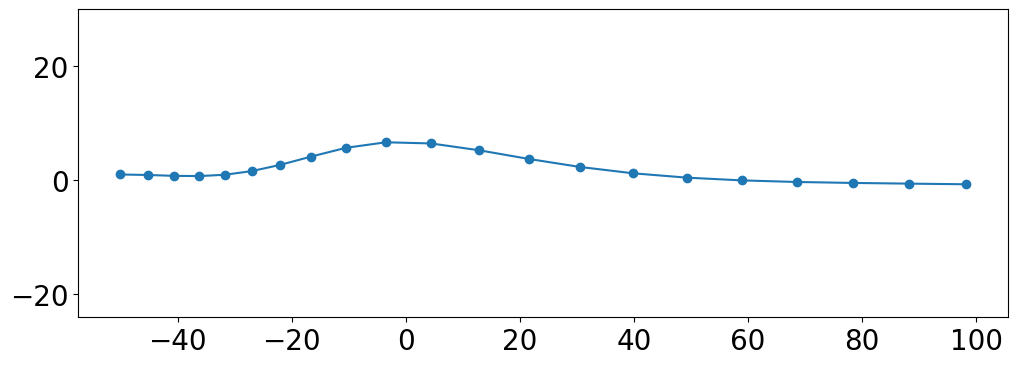

In [24]:
solution = iterative_linear_quadratic_regulator(
    RK4Integrator(PointMassVehicleDynamics(), 0.5),
    TotalCost(
        VehicleExampleRunningCost(soft_acceleration_limit=6.0),
        VehicleExampleTerminalCost(gain=1.0),
    ),
    np.array([-50., 1., 0., 10.]),
    np.zeros((20, 2)),
)
states, controls = solution["optimal_trajectory"]
x, y, q, v = states.T
a, k = controls.T
a_lat = v[:-1]**2 * k
plt.figure(figsize=(12, 4))
plt.plot(x, y, marker="o")
plt.axis("equal")

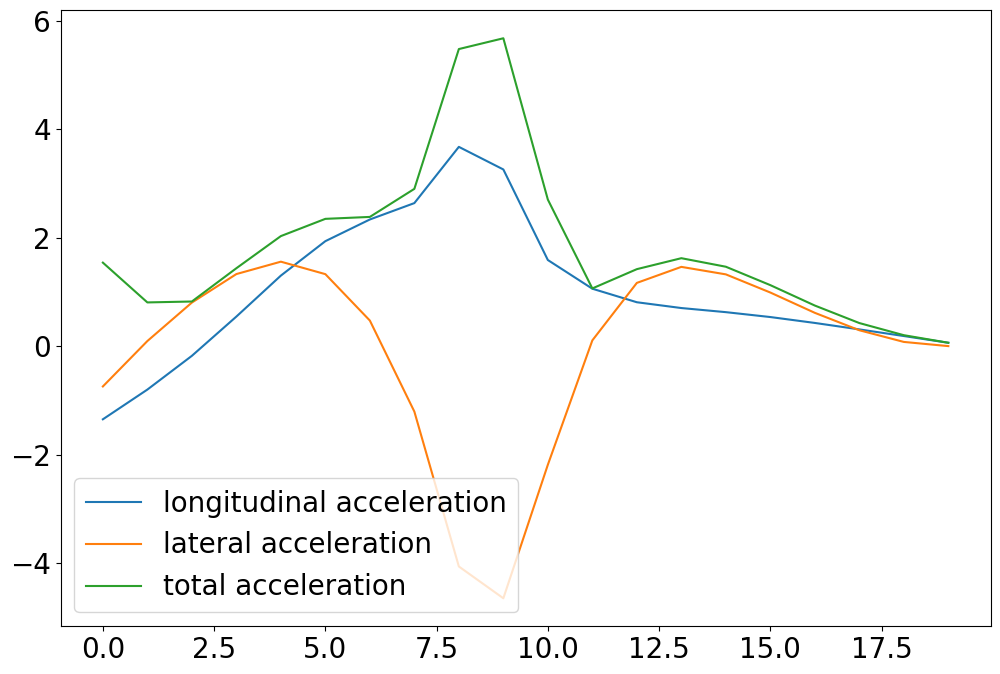

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(a, label="longitudinal acceleration")
plt.plot(a_lat, label="lateral acceleration")
plt.plot(np.hypot(a, a_lat), label="total acceleration")
plt.legend(loc="lower left")

In [26]:
%%timeit
solution = iterative_linear_quadratic_regulator(
    RK4Integrator(PointMassVehicleDynamics(), 0.5),
    TotalCost(
        VehicleExampleRunningCost(soft_acceleration_limit=6.0),
        VehicleExampleTerminalCost(gain=1.0),
    ),
    np.array([-50., 1., 0., 10.]),
    np.zeros((20, 2)),
)
jax.tree.map(lambda x: x.block_until_ready(), solution)  # Ensure timing is accurate.

5.98 ms ± 38.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
iterative_linear_quadratic_regulator(
    RK4Integrator(PointMassVehicleDynamics(), 0.5),
    TotalCost(
        VehicleExampleRunningCost(soft_acceleration_limit=6.0),
        VehicleExampleTerminalCost(gain=1.0),
    ),
    np.array([-50., 1., 0., 10.]),
    np.zeros((20, 2)),
)["num_iterations"]

Array(13, dtype=int32, weak_type=True)